<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C7/C7.html"><img src="../data/C7_nav.png" width="100"  style="float:right;" alt="C7"></a>
<h1>Subsequence DTW</h1> 
</div>

<br/>

<p>
Following Section 7.2.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook a subsequence variant of dynamic time warping (DTW).

</p> 

## Gobal and Subsequence Alignment

In [FMP notebook on dynamic time warping (DTW)](../C3/C3S2_DTWbasic.html), we studied how one can deal with tempo differences when comparing two feature sequences. Based on the notion of a **warping path**, we computed an optimal **global alignment** between the two sequences using the DTW algorithm. In the [audio matching scenario](../C7/C7_ContentBasedAudioRetrieval.html), the alignment task is slightly different. Instead of finding a global alignment between the two given sequences, the objective is to find a subsequence within the longer sequence that optimally fits the shorter sequence. The two different alignment tasks are illustrated by the following figure.


<img src="../data/C7/FMP_C7_F13+.png" width="800px" align="middle" alt="FMP_C7_F13+.png">

## Problem Formalization

To mathematically model our subsequence alignment problem, we adopt the notation introduced in Section 3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. Let $X=(x_1,x_2,\ldots,x_N)$ and $Y=(y_1,y_2,\ldots,y_M)$ be two feature sequences over the feature space $\mathcal{F}$, where we assume that 
the length $M$ is much larger than the length $N$. Furthermore, let $c:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$ be a local cost measure and $\mathbf{C}$ the resulting cost matrix given by $\mathbf{C}(n,m)=c(x_n,y_m)$ for $n\in[1:N]$ and $m\in[1:M]$. For two indices $a,b\in[1:M]$ with $a\leq b$, we use the notation

\begin{equation}
   Y(a:b):=(y_a,y_{a+1},\ldots,y_b)
\end{equation}

to denote a subsequence of $Y$. Based on the [global DTW distance](../C3/C3S2_DTWbasic.html), our matching problem can be formulated as the following optimization task: find the subsequence of $Y$ (over all possible subsequences of $Y$) that minimizes the DTW distance to $X$. In other words, the task is to determine the indices defined by

\begin{equation}
   (a^\ast,b^\ast) := \underset{(a,b): 1\leq a\leq b\leq M}{\mathrm{argmin}}
   \mathrm{DTW}\big( X\,,\, Y(a:b)\big).
\end{equation}

## Subsequence DTW Algorithm

Finding $(a^\ast,b^\ast)$ seems to involve two different kinds of optimization steps. First, one needs to consider all possible subsequences of $Y$ to find the optimal one. Second, for each subsequence in turn, one needs to compute the DTW distance to $X$, which itself involves an optimization for determining the cost of an optimal warping path. The good news is that both, the indices $a^\ast$ and $b^\ast$ as well as an optimal alignment between $X$ and the subsequence  $Y(a^\ast:b^\ast)$, can be computed within a single optimization framework. Only a slight modification of the original DTW algorithm is necessary. The basic idea is to allow for omissions at the beginning and at the end of $Y$ in the alignment with $X$. Instead of giving a formal proof of the entire procedure, we describe in the following only the necessary modifications.

As with the [original DTW algorithm](../C3/C3S2_DTWbasic.html), one defines an $N\times M$ **accumulated cost matrix** denoted by $\mathbf{D}$. The first column of this matrix is initialized by setting 

\begin{equation}
   \mathbf{D}(n,1):=\sum_{k=1}^{n} \mathbf{C}(k,1)
\end{equation}

for $n\in [1:N]$. However, the first row of $\mathbf{D}$ is now initialized by 

\begin{equation}
   \mathbf{D}(1,m):= \mathbf{C}(1,m)
\end{equation}

for $m\in [1:M]$. This initialization makes it possible to start at any position of the sequence $Y$ without accumulating any cost, thus realizing the idea of skipping the beginning of $Y$ when being matched to $X$. The remaining values of $\mathbf{D}$ are defined recursively as in the original [DTW algorithm](../C3/C3S2_DTWbasic.html):

$$
    \mathbf{D}(n,m) = \mathbf{C}(n,m) + \mathrm{min}\big\{ \mathbf{D}(n-1,m-1), \mathbf{D}(n-1,m), \mathbf{D}(n,m-1) \big\}
$$

for $n\in[2:N]$ and $m\in[2:M]$. Finally, instead of looking only at the coefficient $\mathbf{D}(N,M)$ to obtain the global [DTW distance](../C3/C3S2_DTWbasic.html), the second modification is to consider the entire last row $\mathbf{D}(N,m)$ for $m\in[1:M]$. From this row, the index $b^\ast$ can be determined by

\begin{equation}
   b^\ast = \underset{b\in[1:M]}{\mathrm{argmin}} \,\,\mathbf{D}(N,b).
\end{equation}

Choosing the **cost-minimizing index** in this row (instead of taking the last index as is done in the original DTW approach) realizes the idea of skipping the end of $Y$ when being matched to $X$. The start index $a^\ast$ cannot be directly read off from the matrix $\mathbf{D}(N,m)$. To determine $a^\ast$, one needs to apply a **backtracking procedure** as in classical DTW to construct an optimal warping path. This time, however, one starts with $q_1=(N,b^\ast)$ (instead of $q_1=(N,M)$) and stops as soon as the first row of $\mathbf{D}$ is reached by some element $q_L=(1,m)$, $m\in[1:M]$ (instead of $q_L=(1,1))$. The index $a^\ast\in[1:M]$ is then determined by this index $m$. Furthermore, the path $(q_L,q_{L-1},\ldots,q_1)$ defines an optimal warping path between the sequence $X$ and the subsequence $Y(a^\ast:b^\ast)$. The subsequence DTW algorithm is specified by the following table.

<img src="../data/C7/FMP_C7_E06.png" width="600px" align="middle" alt="FMP_C7_E06.png">

## Implementation

We now implement the **Subsequence DTW** algorithm as described above. As an illustrative example, we consider two sequences of real numbers and the absolute value of differences (one-dimensional Euclidean distance) as cost measure. In other words, we have the feature space $\mathcal{F}=\mathbb{R}$ and $c(x,y):=|x-y|$ for $x,y\in \mathcal{F}$.

<div class="alert alert-block alert-warning">
<strong>Note:</strong> As in the <a href="../C3/C3S2_DTWbasic.html/">original DTW algorithm</a>, the implementation differs from the mathematical description above since Python indexing starts with the index 0. In particular, this applies to: 

* Sequences:  ``X = X[0], ..., X[N-1]`` and ``Y = Y[0], ..., Y[M-1]``
* Cost matrix and accumulated cost matrix: ``C[0, 0], ..., C[N-1, M-1]`` and ``D[0, 0], ..., D[N-1, M-1]``
* Warping path: ``P = P[0], ..., P[L-1]`` with ``P[0] = (0, a*)`` and ``P[L-1] = (N-1, b*)``
</div>

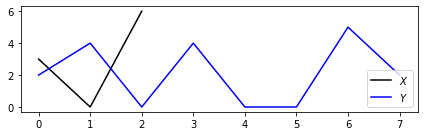

Sequence X = [3 0 6]
Sequence Y = [2 4 0 4 0 0 5 2]


In [1]:
import os
import sys
import numpy as np
import librosa
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import patches

sys.path.append('..')
import LibFMP.B
import LibFMP.C3
import LibFMP.C7
%matplotlib inline

X = np.array([3, 0, 6])
Y = np.array([2, 4, 0, 4, 0, 0, 5, 2])
N = len(X)
M = len(Y)

plt.figure(figsize=(6, 2))
plt.plot(X, c='k', label='$X$')
plt.plot(Y, c='b', label='$Y$')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print('Sequence X =', X)
print('Sequence Y =', Y)

We now compute the cost matrix $C$ using the Euclidean distance as local cost measure:

In [2]:
C =  LibFMP.C3.compute_cost_matrix(X, Y, metric='euclidean')
print('Cost matrix C =', C, sep='\n')

Cost matrix C =
[[1. 1. 3. 1. 3. 3. 2. 1.]
 [2. 4. 0. 4. 0. 0. 5. 2.]
 [4. 2. 6. 2. 6. 6. 1. 4.]]


Next, using dynamic programming, we compute the **accumulated cost matrix** $D$ and the cost-minimizing index $b^\ast$ in the last row of $D$.

In [3]:
@jit(nopython=True)
def compute_accumulated_cost_matrix_subsequenceDTW(C):
    """Given the cost matrix, compute the accumulated cost matrix for
       subsequence dynamic time warping with step sizes {(1, 0), (0, 1), (1, 1)}

    Notebook: C7/C7S2_SubsequenceDTW.ipynb

    Args:
        C: cost matrix

    Returns:
        D: Accumulated cost matrix
    """
    N, M = C.shape
    D = np.zeros((N, M))
    D[:, 0] = np.cumsum(C[:, 0])
    D[0, :] = C[0, :]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D =  compute_accumulated_cost_matrix_subsequenceDTW(C)
print('Accumulated cost matrix D =', D, sep='\n')
b_ast = D[-1, :].argmin()
print('b* =', b_ast)
print('Accumulated cost D[N, b*] = ', D[-1, b_ast])

Accumulated cost matrix D =
[[1. 1. 3. 1. 3. 3. 2. 1.]
 [3. 5. 1. 5. 1. 1. 6. 3.]
 [7. 5. 7. 3. 7. 7. 2. 6.]]
b* = 6
Accumulated cost D[N, b*] =  2.0


Finally, we derive the optimal warping path $P^\ast$ using backtracking, which determines the index $a^\ast$ of the optimal subsequence $Y(a^\ast:b^\ast)$.

In [4]:
@jit(nopython=True)
def compute_optimal_warping_path_subsequenceDTW(D, m=-1):
    """Given an accumulated cost matrix, compute the warping path for
       subsequence dynamic time warping with step sizes {(1, 0), (0, 1), (1, 1)}

    Notebook: C7/C7S2_SubsequenceDTW.ipynb

    Args:
        D: Accumulated cost matrix
        m: Index to start back tracking; if set to -1, optimal m is used

    Returns
        P: Warping path (list of index pairs)
    """
    N, M = D.shape
    n = N - 1
    if m < 0:
        m = D[N - 1, :].argmin()
    P = [(n, m)]

    while n > 0:
        if m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        n, m = cell
    P.reverse()
    P = np.array(P)
    return P
        
P = compute_optimal_warping_path_subsequenceDTW(D)
print('Optimal warping path P =', P.tolist())
a_ast = P[0, 1]
b_ast = P[-1, 1]
print('a* =', a_ast)
print('b* =', b_ast)
print('Sequence X =', X)
print('Sequence Y =', Y)
print('Optimal subsequence Y(a*:b*) =', Y[a_ast:b_ast+1])
print('Accumulated cost D[N, b_ast]= ', D[-1, b_ast])

Optimal warping path P = [[0, 3], [1, 4], [1, 5], [2, 6]]
a* = 3
b* = 6
Sequence X = [3 0 6]
Sequence Y = [2 4 0 4 0 0 5 2]
Optimal subsequence Y(a*:b*) = [4 0 0 5]
Accumulated cost D[N, b_ast]=  2.0


Finally, we visualize the cost matrix $C$ and the accumulated cost matrix $D$ of our subsequence DTW approach along with the optimal warping path (indicated by the red dots).

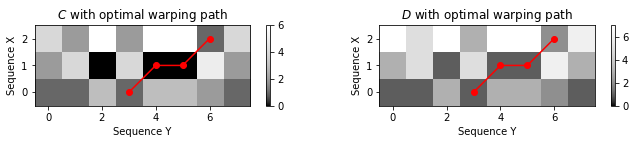

In [5]:
cmap = LibFMP.B.compressed_gray_cmap(alpha=-10, reverse=True)

plt.figure(figsize=(10, 1.8))
ax = plt.subplot(1, 2, 1)
LibFMP.C3.plot_matrix_with_points(C, P, linestyle='-', ax=[ax], aspect='equal',
                                  clim=[0, np.max(C)], cmap=cmap, title='$C$ with optimal warping path',
                                  xlabel='Sequence Y', ylabel='Sequence X')

ax = plt.subplot(1, 2, 2)
LibFMP.C3.plot_matrix_with_points(D, P, linestyle='-', ax=[ax], aspect='equal',
                                  clim=[0, np.max(D)], cmap=cmap, title='$D$ with optimal warping path',
                                  xlabel='Sequence Y', ylabel='Sequence X')

plt.tight_layout()

## Matching Function

Besides revealing the optimal index $b^\ast$, the last row of $\mathbf{D}$ (top row in the visualization) provides more information. Each entry $\mathbf{D}(N,m)$ for an arbitrary $m\in[1:M]$ indicates the total cost of aligning $X$ with an optimal subsequence of $Y$ that ends at position $m$. This motivates us to define a **matching function** $\Delta_\mathrm{DTW}:[1:M]\to\mathbb{R}$ by setting

\begin{equation}
 \Delta_\mathrm{DTW}(m) :=  \frac{1}{N}\,\, \mathbf{D}(N,m)
\end{equation}

for $m\in[1:M]$, where we have normalized the accumulated cost by the length $N$ of the query. Each local minimum $b\in[1:M]$ of $\Delta_\mathrm{DTW}$ that is close to zero indicates the end position of a subsequence $Y(a:b)$ that has a small DTW distance to $X$. The start index $a\in[1:M]$ as well as the optimal alignment between this subsequence and $X$ are obtained by a backtracking procedure starting with the cell $q_1=(N,b)$. The following example shows the matching function of our previous example. 

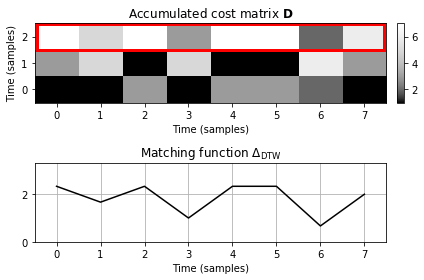

In [6]:
Delta = D[-1, :] / N 

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.02], 
                                          'height_ratios': [1, 1]}, figsize=(6, 4))  
cmap = LibFMP.B.compressed_gray_cmap(alpha=-10, reverse=True)
LibFMP.B.plot_matrix(D, title=r'Accumulated cost matrix $\mathbf{D}$', xlabel='Time (samples)',
                     ylabel='Time (samples)',  ax=[ax[0, 0], ax[0, 1]], colorbar=True, cmap=cmap)
rect = patches.Rectangle((-0.45, 1.48), len(Delta)-0.1, 1, linewidth=3, edgecolor='r', facecolor='none')
ax[0, 0].add_patch(rect)

LibFMP.B.plot_signal(Delta, ax=ax[1, 0], xlabel='Time (samples)', ylabel='', ylim=[0, np.max(Delta)+1], 
                     title = r'Matching function $\Delta_\mathrm{DTW}$', color='k')
ax[1, 0].set_xlim([-0.5, len(Delta)-0.5])
ax[1, 0].grid()
ax[1, 1].axis('off')
plt.tight_layout()

## Comparison with Diagonal Matching

The matching function $\Delta_\mathrm{DTW}$ using subsequence DTW can be regarded as a kind of generalization of the matching function $\Delta_\mathrm{Diag}$ obtained by <a href="C7S2_DiagonalMatching.html">diagonal matching</a>. However, there are crucial differences between $\Delta_\mathrm{Diag}$ and $\Delta_\mathrm{DTW}$:

* While $\Delta_\mathrm{Diag}$ reveals **start positions** of matching sections, the matching function $\Delta_\mathrm{DTW}$ indicates **end positions** of matching sections. In simple terms, in diagonal matching, the query $X$ is processed in forward direction, whereas in the DTW-based approach it is processed in backward direction. 

* Furthermore, instead of just diagonally aligning the matching section with the query, the DTW-based approach introduces warping operations that make it possible to handle temporal deviations between the match and the query. 

This effect becomes visible in our running example from above, where the query sequence $X$ has length $N=3$, while the best matching subsequence $Y(3:6)$ has length $4$. The DTW-based matching procedure can account for such temporal differences. By using diagonal matching, however, the length of the matching subsequence is forced to have the same length $N$ as the query $X$. This leads to a different optimal subsequence as in the DTW-based matching. 

<!--
The following figure shows the cost matrix and the matching functions $\Delta_\mathrm{DTW}$ and $\Delta_\mathrm{Diag}$:
<img src="../data/C7/FMP_C7_F14a-c_text.png" width="500px" align="middle" alt="FMP_C7_F14d-e_text.png">
<img src="../data/C7/FMP_C7_F14d-e_text.png" width="500px" align="middle" alt="FMP_C7_F14d-e_text.png">
-->

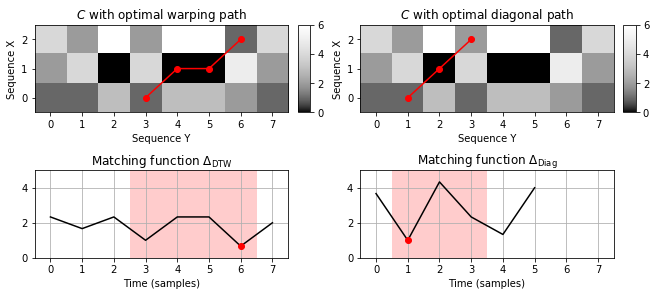

In [7]:
N = len(X)
M = len(Y)
C =  LibFMP.C3.compute_cost_matrix(X, Y, metric='euclidean')

# Subsequence DTW
D =  compute_accumulated_cost_matrix_subsequenceDTW(C)
Delta_DTW = D[-1, :] / N 
P_DTW = compute_optimal_warping_path_subsequenceDTW(D)
a_ast = P[0, 1]
b_ast = P[-1, 1]

# Diagonal matching
Delta_Diag = LibFMP.C7.matching_function_diag(C)
m = np.argmin(Delta_Diag)
P_Diag = []
for n in range(N): 
    P_Diag.append((n, m+n))
P_Diag = np.array(P_Diag)
matches_Diag = [(m, N)]


# Visualization
fig, ax = plt.subplots(2, 4, gridspec_kw={'width_ratios': [1, 0.05, 1, 0.05], 
                                          'height_ratios': [1, 1]}, 
                       constrained_layout=True, figsize=(9, 4))  
cmap = LibFMP.B.compressed_gray_cmap(alpha=-10, reverse=True)
LibFMP.C3.plot_matrix_with_points(C, P_DTW, linestyle='-', ax=[ax[0, 0], ax[0, 1]],
                                  clim=[0, np.max(C)], cmap=cmap, title='$C$ with optimal warping path',
                                  xlabel='Sequence Y', ylabel='Sequence X')
LibFMP.B.plot_signal(Delta_DTW, ax=ax[1,0], xlabel='Time (samples)', ylabel='', ylim=[0, 5],
                     title=r'Matching function $\Delta_\mathrm{DTW}$', color='k')
ax[1, 0].set_xlim([-0.5, len(Delta)-0.5])
ax[1, 0].grid()
ax[1, 0].plot(b_ast, Delta_DTW[b_ast], 'ro')
ax[1, 0].add_patch(patches.Rectangle((a_ast-0.5, 0), b_ast-a_ast+1, 7, facecolor='r', alpha=0.2))
ax[1, 1].axis('off')

LibFMP.C3.plot_matrix_with_points(C, P_Diag, linestyle='-', ax=[ax[0, 2], ax[0, 3]],
                                  clim=[0, np.max(C)], cmap=cmap, title='$C$ with optimal diagonal path',
                                  xlabel='Sequence Y', ylabel='Sequence X')
LibFMP.B.plot_signal(Delta_Diag, ax=ax[1, 2], xlabel='Time (samples)', ylabel='', 
                     ylim=[0, 5], title = r'Matching function $\Delta_\mathrm{Diag}$', color='k')
ax[1, 2].set_xlim([-0.5, len(Delta)-0.5])
ax[1, 2].grid()
ax[1, 2].plot(m, Delta_Diag[m], 'ro')
ax[1, 2].add_patch(patches.Rectangle((m-0.5, 0), N, 7, facecolor='r', alpha=0.2))
ax[1, 3].axis('off');

## Step Size Condition

The discussed subsequence variant of DTW can be modified in the same way as [classical DTW](../C3/C3S2_DTWbasic.html). In particular, the [**step size condition**](../C3/C3S2_DTWvariants.html) may be changed by replacing the set $\Sigma=\{(1,0),(0,1),(1,1)\}$. For example, using the set $\Sigma=\{(1,1)\}$, DTW-based matching basically reduces to diagonal matching&mdash;except for the backward processing instead of the forward processing. In general, using the set $\Sigma=\{(1,0),(0,1),(1,1)\}$ may lead to alignment paths that are highly deteriorated. In the extreme case, the sequence $X$ may be assigned to a single element of $Y$. Therefore, in certain applications, it may be beneficial to use the set $\Sigma=\{(2,1),(1,2),(1,1)\}$, which yields a compromise between the strict diagonal matching and the DTW-based matching with the full flexibility. Similar to the [FMP notebook on DTW variants](../C3/C3S2_DTWvariants.html), we provide in the following code cell a subsequence DTW variant with the step size condition $\Sigma=\{(2,1),(1,2),(1,1)\}$.

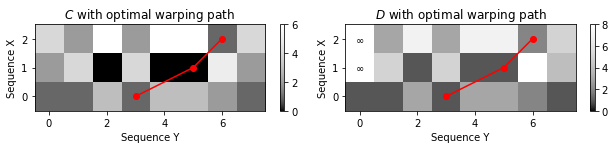

In [8]:
@jit(nopython=True)
def compute_accumulated_cost_matrix_subsequenceDTW_21(C):
    """Given the cost matrix, compute the accumulated cost matrix for 
    subsequence dynamic time warping with step sizes {(1, 1), (2, 1), (1, 2)}

    Notebook: C7/C7S2_SubsequenceDTW.ipynb

    Args:
        C: cost matrix

    Returns:
        D: Accumulated cost matrix
    """
    N, M = C.shape
    D = np.zeros((N + 1, M + 2))
    D[0:1, :] = np.inf
    D[:, 0:2] = np.inf
    
    D[1, 2:] = C[0, :]
    
    for n in range(1, N):
        for m in range(0, M):
            if n == 0 and m == 0:
                continue
            D[n+1, m+2] = C[n, m] + min(D[n-1+1, m-1+2], D[n-2+1, m-1+2], D[n-1+1, m-2+2])
    D = D[1:, 2:]
    return D


@jit(nopython=True)
def compute_optimal_warping_path_subsequenceDTW_21(D, m=-1):
    """Given an accumulated cost matrix, compute the warping path for
    subsequence dynamic time warping with step sizes {(1, 1), (2, 1), (1, 2)}

    Notebook: C7/C7S2_SubsequenceDTW.ipynb

    Args:
        D: Accumulated cost matrix
        m: Index to start back tracking; if set to -1, optimal m is used

    Returns
        P: Warping path (list of index pairs)
    """
    N, M = D.shape
    n = N - 1
    if m < 0:
        m = D[N - 1, :].argmin()
    P = [(n, m)]

    while n > 0:
        if m == 0:
            cell = (n-1, 0)
        else:
            val = min(D[n-1, m-1], D[n-2, m-1], D[n-1, m-2])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-2, m-1]:
                cell = (n-2, m-1)
            else:
                cell = (n-1, m-2)
        P.append(cell)
        n, m = cell
    P.reverse()
    P = np.array(P)
    return P

C =  LibFMP.C3.compute_cost_matrix(X, Y, metric='euclidean')
D = compute_accumulated_cost_matrix_subsequenceDTW_21(C)
P = compute_optimal_warping_path_subsequenceDTW_21(D)

plt.figure(figsize=(9, 1.8))
ax = plt.subplot(1, 2, 1)
LibFMP.C3.plot_matrix_with_points(C, P, linestyle='-', ax=[ax], aspect='equal',
                                  clim=[0, np.max(C)], cmap=cmap, title='$C$ with optimal warping path',
                                  xlabel='Sequence Y', ylabel='Sequence X')

ax = plt.subplot(1, 2, 2)
D_max = np.nanmax(D[D != np.inf])
LibFMP.C3.plot_matrix_with_points(D, P, linestyle='-', ax=[ax], aspect='equal',
                                  clim=[0, D_max], cmap=cmap, title='$D$ with optimal warping path', 
                                  xlabel='Sequence Y', ylabel='Sequence X')
for x, y in zip(*np.where(np.isinf(D))):
    plt.text(y, x, '$\infty$', horizontalalignment='center', verticalalignment='center')
    
plt.tight_layout()

## LibROSA and LibFMP Implemetations


The DTW function `librosa.sequence.dtw` of [LibROSA](https://librosa.github.io/librosa/) implements both the original DTW as well as subsequence DTW. For the latter case, one needs to set the parameter `subseq=True`. This function allows for specifying arbitrary step size conditions as well as additional parameters such as **local weights** and **global constraints**. For details, we refer to the [FMP notebook on DTW variants](../C3/C3S2_DTWvariants.html). In the following, we compare the DTW implementations of `librosa` and `LibFMP`. To this end, we consider the beginning of [Beethoven's Fifth Symphony](../C1/C1S1_SheetMusic.html) as a concrete audio matching example. 

* The query consists of a Bernstein recording of the first five measure.
* The database document consists of a Karajan version of the first $21$ measures.
* The matching is performed on the basis of [CENS-feature](../C7/C7S2_CENS.html) sequences.  

<img src="../data/C7/FMP_C7_Audio_Beethoven_Op067-01-001-021_Sibelius-Piano.png" width="700px" align="left" alt="C7">

<br clear="all" />

<audio src="../data/C7/FMP_C7_Audio_Beethoven_Op067-01-001-005_Bernstein.mp3" type="audio/mpeg" controls="controls"></audio>
<audio src="../data/C7/FMP_C7_Audio_Beethoven_Op067-01-001-021_Karajan.mp3" type="audio/mpeg" controls="controls"></audio>

First, let us consider subsequence DTW with the step size condition $\Sigma=\{(0, 1), (1, 0), (1, 1)\}$.

D matrices are equal.
Warping paths are equal.


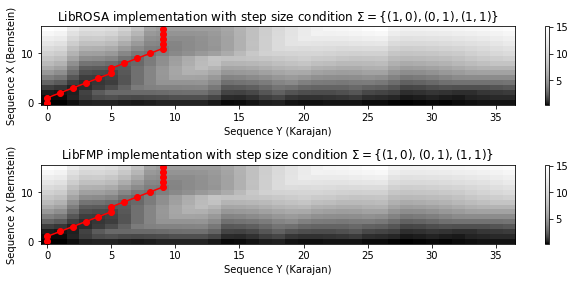

In [9]:
def check_matrices(M1, M2, label='Matrices'):
    if (M1.shape != M2.shape):
        print(label, 'have different shape!', (M1.shape, M2.shape))
    elif not np.allclose(M1, M2):
        print(label, 'are numerical different!')
    else:
        print(label, 'are equal.')
        
        
Fs = 22050
N_feat = 4410
H_feat = 2205

data_dir = os.path.join('..', 'data', 'C7')
fn1 = os.path.join(data_dir, 'FMP_C7_Audio_Beethoven_Op067-01-001-005_Bernstein.wav')
fn2 = os.path.join(data_dir, 'FMP_C7_Audio_Beethoven_Op067-01-001-021_Karajan.wav')

x1, Fs = librosa.load(fn1, sr=Fs)
x2, Fs = librosa.load(fn2, sr=Fs)
C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=None, hop_length=H_feat, n_fft=N_feat)
C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=None, hop_length=H_feat, n_fft=N_feat)
ell = 21
d = 5
X, Fs_cens = LibFMP.C7.compute_CENS_from_chromagram(C1, ell=21, d=5)
Y, Fs_cens = LibFMP.C7.compute_CENS_from_chromagram(C2, ell=21, d=5)
N, M = X.shape[1], Y.shape[1]

C_FMP = LibFMP.C3.compute_cost_matrix(X, Y, 'euclidean')
#C_FMP = LibFMP.C7.cost_matrix_dot(X, Y)
D_FMP = LibFMP.C7.compute_accumulated_cost_matrix_subsequenceDTW(C_FMP)
P_FMP = LibFMP.C7.compute_optimal_warping_path_subsequenceDTW(D_FMP)
    
sigma = np.array([[1, 0], [0, 1], [1, 1]])
#D_librosa, P_librosa = librosa.sequence.dtw(X, Y, metric='euclidean',
#                                            step_sizes_sigma=sigma, subseq=True, 
#                                            backtrack=True)
D_librosa, P_librosa = librosa.sequence.dtw(C=C_FMP, step_sizes_sigma=sigma, subseq=True, 
                                            backtrack=True)
P_librosa = P_librosa[::-1, :]

check_matrices(D_librosa, D_FMP, 'D matrices')
check_matrices(P_librosa, P_FMP, 'Warping paths')
    
fig, ax = plt.subplots(2, 1, figsize=(9, 4))
title='LibROSA implementation with step size condition $\Sigma=\{(1, 0), (0, 1), (1, 1)\}$'
LibFMP.C3.plot_matrix_with_points(D_librosa, P_librosa, ax=[ax[0]], cmap=cmap, 
                                  xlabel='Sequence Y (Karajan)', ylabel='Sequence X (Bernstein)', 
                                  title=title,
                                  marker='o', linestyle='-')
title='LibFMP implementation with step size condition $\Sigma=\{(1, 0), (0, 1), (1, 1)\}$'
LibFMP.C3.plot_matrix_with_points(D_FMP, P_FMP, ax=[ax[1]], cmap=cmap,
                                  xlabel='Sequence Y (Karajan)', ylabel='Sequence X (Bernstein)',
                                  title=title,
                                  marker='o', linestyle='-')
plt.tight_layout()

Next, let us consider subsequence DTW with step size condition $\Sigma=\{(2, 1), (1, 2), (1, 1)\}$.

D matrices are equal.
Warping paths are equal.


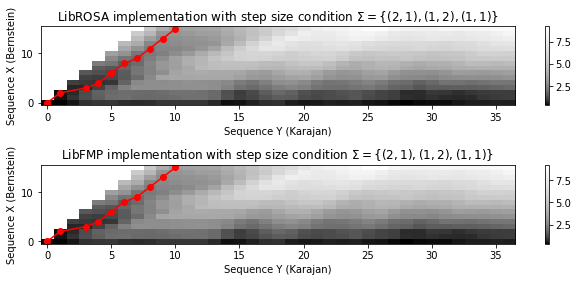

In [10]:
C_FMP = LibFMP.C3.compute_cost_matrix(X, Y, 'euclidean')
D_FMP = LibFMP.C7.compute_accumulated_cost_matrix_subsequenceDTW_21(C_FMP)
P_FMP = LibFMP.C7.compute_optimal_warping_path_subsequenceDTW_21(D_FMP)
    
sigma = np.array([[2, 1], [1, 2], [1, 1]])
#D_librosa, P_librosa = librosa.sequence.dtw(X, Y, metric='euclidean',
#                                            step_sizes_sigma=sigma, subseq=True, 
#                                            backtrack=True)
D_librosa, P_librosa = librosa.sequence.dtw(C=C_FMP, step_sizes_sigma=sigma, subseq=True, 
                                            backtrack=True)

P_librosa = P_librosa[::-1, :]

check_matrices(D_librosa, D_FMP, 'D matrices')
check_matrices(P_librosa, P_FMP, 'Warping paths')
    
fig, ax = plt.subplots(2, 1, figsize=(9, 4))
title='LibROSA implementation with step size condition $\Sigma=\{(2, 1), (1, 2), (1, 1)\}$'
LibFMP.C3.plot_matrix_with_points(D_librosa, P_librosa, ax=[ax[0]], cmap=cmap,
                                  xlabel='Sequence Y (Karajan)', ylabel='Sequence X (Bernstein)',
                                  title=title,
                                  marker='o', linestyle='-')
title='LibFMP implementation with step size condition $\Sigma=\{(2, 1), (1, 2), (1, 1)\}$'
LibFMP.C3.plot_matrix_with_points(D_FMP, P_FMP, ax=[ax[1]], cmap=cmap,
                                  xlabel='Sequence Y (Karajan)', ylabel='Sequence X (Bernstein)',
                                  title=title,
                                  marker='o', linestyle='-')
plt.tight_layout()

## Further Notes

In this notebook, we discussed a subsequence variant of DTW. While [classical DTW](../C3/C3S2_DTWbasic.html) computes an optimal **global** alignment, subsequence DTW yields an optimal **local** alignment between the first sequence and an optimally matching section of the second sequence. The algorithm is the same as for classical DTW except for a different initialization of the first row and a different evaluation of the last row. 

* As the [LibROSA](https://librosa.github.io/librosa/) implementation shows, there exists the same [variants](../C3/C3S2_DTWvariants.html) for subsequence DTW (e.g., step size conditions, local weights, and global constraints) as for classical DTW. 

* The last row of the accumulated cost matrix can be interpreted as a matching function. Similar to the [diagonal matching function](../C7/C7S2_DiagonalMatching.html), local minima close to zero indicate subsequences of the second sequence that match the first sequence. We will apply and further explore the concept of matching functions in the [FMP notebook on audio matching](../C7/C7S2_AudioMatching.html).

* Further relaxing the [boundary condition](../C3/C3S2_DTWbasic.html) leads to the task of finding possibly long similar subsequences contained in the two given sequences. We will discuss this alignment problem in the [FMP notebook on common subsequence matching](../C7/C7S3_CommonSubsequence.html).

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>